In [1]:
#


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the data
data_path = 'dairy_product.csv'
data = pd.read_csv(data_path)
data.info()

# Step 2: Handle missing values
missing_percentage = data.isnull().sum() / len(data) * 100
columns_to_drop = missing_percentage[missing_percentage > 80].index
print('\ncolumns_to_drop: ', columns_to_drop)
data = data.drop(columns=columns_to_drop)

# Step 3: Label encode categorical features
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Step 4: Extract independent and dependent variables
# Assuming 'target' is the dependent variable
if 'FoodGroup' in data.columns:
    y = data['FoodGroup']
    X = data.drop(columns=['FoodGroup', 'ID', 'Descrip', 'ShortDescrip'])
else:
    raise ValueError("No 'target' column found in the dataset. Please specify the dependent variable.")

# Step 5: Identify and print low-variance data
selector = VarianceThreshold(threshold=0.01)  # Threshold can be adjusted
selector.fit(X)
low_variance_features = X.columns[~selector.get_support()]
print("\nLow-variance features:", low_variance_features.tolist())

# Step 6: Feature importance using Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature importances RF:")
print(feature_importances)

# Step 7: Drop highly correlated columns
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
print('<nhighly_correlated: ', highly_correlated )
X = X.drop(columns=highly_correlated)

print("\nRemaining columns after removing high correlation:", X.columns.tolist())

# Save processed data (optional)
X.to_csv('processed_X.csv', index=False)
y.to_csv('processed_y.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8618 non-null   int64  
 1   FoodGroup         8618 non-null   object 
 2   ShortDescrip      8618 non-null   object 
 3   Descrip           8618 non-null   object 
 4   CommonName        1063 non-null   object 
 5   MfgName           1560 non-null   object 
 6   ScientificName    732 non-null    object 
 7   Energy_kcal       8618 non-null   float64
 8   Protein_g         8618 non-null   float64
 9   Fat_g             8618 non-null   float64
 10  Carb_g            8618 non-null   float64
 11  Sugar_g           8618 non-null   float64
 12  Fiber_g           8618 non-null   float64
 13  VitA_mcg          8618 non-null   float64
 14  VitB6_mg          8618 non-null   float64
 15  VitB12_mcg        8618 non-null   float64
 16  VitC_mg           8618 non-null   float64


In [12]:
# Question2 


C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


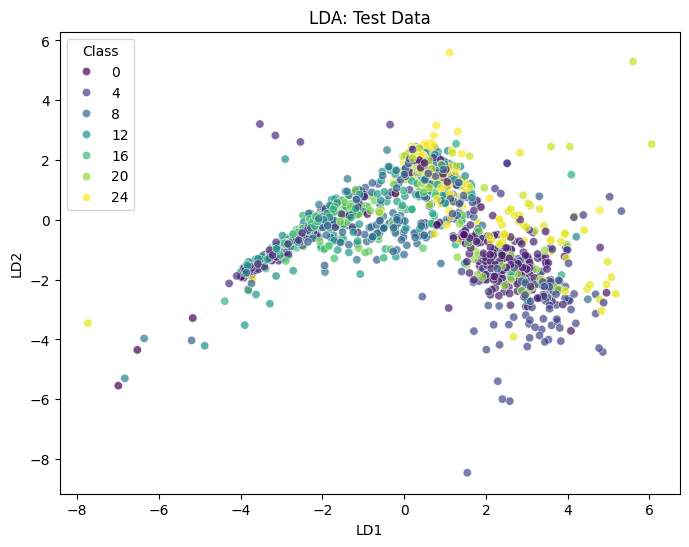

C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.48
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.18      0.19        22
           1       0.38      0.32      0.35        74
           2       0.57      0.75      0.65       158
           3       0.65      0.74      0.69       168
           4       0.39      0.24      0.30        66
           5       0.63      0.64      0.64        64
           6       0.53      0.31      0.40        51
           7       0.36      0.21      0.27        66
           8       0.49      0.60      0.54        72
           9       0.70      0.61      0.65        46
          10       0.47      0.37      0.41        57
          11       0.39      0.54      0.45        59
          12       0.34      0.30      0.32        89
          13       0.31      0.30      0.30        74
          14       0.15      0.10      0.12        20
          15       0.29      0.19      0.23        21
          16       0.25      

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load processed data
X = pd.read_csv('processed_X.csv')
y = pd.read_csv('processed_y.csv')

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Perform LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Plot LDA result for test data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test.squeeze(), palette='viridis', alpha=0.7)
plt.title('LDA: Test Data')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Class')
plt.show()

# Step 5: Build Random Forest model on LDA-transformed data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_lda, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


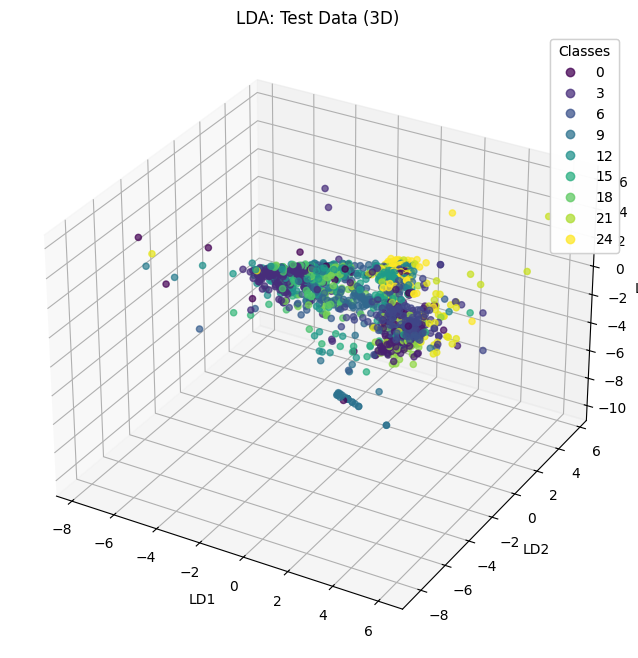

C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.14      0.17        22
           1       0.53      0.42      0.47        74
           2       0.69      0.88      0.78       158
           3       0.69      0.83      0.76       168
           4       0.49      0.33      0.40        66
           5       0.71      0.83      0.76        64
           6       0.61      0.53      0.57        51
           7       0.51      0.38      0.43        66
           8       0.67      0.62      0.65        72
           9       0.79      0.80      0.80        46
          10       0.42      0.39      0.40        57
          11       0.50      0.64      0.56        59
          12       0.41      0.31      0.35        89
          13       0.55      0.51      0.53        74
          14       0.19      0.15      0.17        20
          15       0.54      0.33      0.41        21
          16       0.31      

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Load processed data
X = pd.read_csv('processed_X.csv')
y = pd.read_csv('processed_y.csv')

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Perform LDA with 3 components
lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Plot LDA result for test data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_lda[:, 0], X_test_lda[:, 1], X_test_lda[:, 2], c=y_test.squeeze(), cmap='viridis', alpha=0.7)
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
ax.set_title('LDA: Test Data (3D)')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')
plt.show()

# Step 5: Build Random Forest model on LDA-transformed data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_lda, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Eigenvalues (Explained Variance Ratio): [0.45669042]
Eigenvectors (Scalings):
[[-1.89632969e-01 -5.60570608e-01 -1.43433562e+00  2.66442596e-01
   3.05050471e-01  8.36150683e-02  1.54174889e-01  1.74385860e-02
  -1.46014224e-01  4.07650031e-02 -6.10558511e-02  6.30163225e-02
  -8.80700107e-02  3.22126207e-02 -4.87761980e-01 -1.83421810e-01
  -1.71731386e-01  1.34434472e-01 -3.03667101e-01  2.72882537e-02]
 [-9.97672981e-01 -7.45653289e-01  5.78048140e-01 -3.86611173e-01
  -4.50483198e-01  1.39816760e-01  6.35867905e-01  2.19856611e-01
  -3.25600649e-01 -1.89856605e-01 -2.97634015e-01 -4.01322585e-01
  -5.53176734e-02 -3.82102184e-01  5.63755983e-01  1.98999813e-01
   2.40393378e-01  1.20480226e-01 -1.24385315e-01  1.84429632e-01]
 [ 1.50406868e+00 -1.15574624e+00  7.59968787e-01 -8.07758255e-01
  -7.33222842e-01 -7.22066101e-01  9.50293955e-02 -4.46662650e-01
   2.10561141e-01  2.20481383e-01  7.98284177e-02 -1.78116180e-01
   3.68822726e-02 -2.64893970e-01  5.34705664e-01  1.54444019e

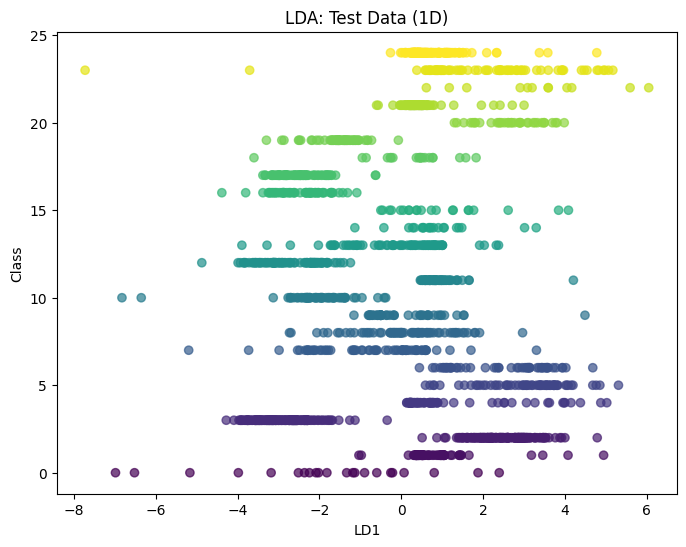

C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.28
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.17      0.15      0.16        74
           2       0.45      0.47      0.46       158
           3       0.50      0.57      0.53       168
           4       0.20      0.18      0.19        66
           5       0.22      0.23      0.23        64
           6       0.22      0.16      0.18        51
           7       0.10      0.08      0.08        66
           8       0.17      0.19      0.18        72
           9       0.42      0.43      0.43        46
          10       0.12      0.11      0.11        57
          11       0.13      0.19      0.15        59
          12       0.36      0.29      0.32        89
          13       0.19      0.20      0.19        74
          14       0.03      0.05      0.04        20
          15       0.19      0.24      0.21        21
          16       0.06      

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Load processed data
X = pd.read_csv('processed_X.csv')
y = pd.read_csv('processed_y.csv')

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Perform LDA with 1 axis
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Eigenvalues and Eigenvectors
eigenvalues = lda.explained_variance_ratio_
eigenvectors = lda.scalings_

print("Eigenvalues (Explained Variance Ratio):", eigenvalues)
print("Eigenvectors (Scalings):")
print(eigenvectors)

# Thresholding Criteria for LDA
threshold = 0.9  # Example: Retain components explaining 90% of the variance
cumulative_variance = eigenvalues.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)
num_components = (cumulative_variance < threshold).sum() + 1
print(f"Number of components to retain (threshold={threshold}): {num_components}")

# Plot LDA result for test data in 1D
plt.figure(figsize=(8, 6))
plt.scatter(X_test_lda, y_test.squeeze(), c=y_test.squeeze(), cmap='viridis', alpha=0.7)
plt.title('LDA: Test Data (1D)')
plt.xlabel('LD1')
plt.ylabel('Class')
plt.show()

# Step 5: Build Random Forest model on LDA-transformed data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_lda, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 1: Load processed data
X = pd.read_csv('processed_X.csv')
y = pd.read_csv('processed_y.csv')

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Fit LDA with maximum components (classes - 1)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Step 5: Compute cumulative explained variance
explained_variance_ratio = lda.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Step 6: Determine the number of components to explain at least 80% variance
threshold = 0.9
num_components = (cumulative_variance >= threshold).argmax() + 1

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)
print(f"Number of components to explain at least {threshold * 100}% variance: {num_components}")

# Step 7: Perform LDA with the determined number of components
lda_reduced = LinearDiscriminantAnalysis(n_components=num_components)
X_train_lda = lda_reduced.fit_transform(X_train, y_train)
X_test_lda = lda_reduced.transform(X_test)

print(f"Shape of LDA-transformed data: {X_train_lda.shape}")


Explained Variance Ratio: [4.56690423e-01 1.68921801e-01 1.32910140e-01 7.42971011e-02
 5.30082855e-02 3.40558773e-02 2.59257977e-02 1.44246059e-02
 1.13154311e-02 8.33732408e-03 6.84633405e-03 5.08619426e-03
 2.92977098e-03 2.26744497e-03 1.12795195e-03 7.84500479e-04
 4.94066478e-04 2.37221798e-04 2.16067484e-04 1.23660737e-04]
Cumulative Explained Variance: [0.45669042 0.62561222 0.75852236 0.83281947 0.88582775 0.91988363
 0.94580943 0.96023403 0.97154946 0.97988679 0.98673312 0.99181932
 0.99474909 0.99701653 0.99814448 0.99892898 0.99942305 0.99966027
 0.99987634 1.        ]
Number of components to explain at least 90.0% variance: 6
Shape of LDA-transformed data: (6894, 6)


C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\akram\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
